# Preprocessing datasets

### Toxic dataset

In [3]:
import pandas as pd
import re
import os

# --- 1. Cleaning and Formatting Functions ---

def extract_most_toxic_sentence(explanation_text):
    """
    Extract the most toxic sentence from the explanation text.
    
    Args:
        explanation_text (str): The explanation string containing the toxic sentence.
        
    Returns:
        str or None: The extracted toxic sentence, 'N/A' if absent, or None if not found.
    """
    if not isinstance(explanation_text, str):
        return None
    clean_explanation = re.sub(r'\s+', ' ', explanation_text)
    match = re.search(r'La frase più tossica è:?\s*.*?"(.*?)"', clean_explanation, re.IGNORECASE)
    if match:
        return match.group(1).strip()
    if "la frase più tossica è assente" in clean_explanation.lower():
        return "N/A"
    return None


def reformat_conversation_hierarchical(row):
    """
    Reformat the conversation text using hierarchical logic:
    1. Extract text between quotes.
    2. If not available, split by 'Name:'.
    3. If not available, split by 'Name'.
    
    Args:
        row (pd.Series): A row of the dataframe containing conversation and names.
    
    Returns:
        str: The cleaned and reformatted conversation.
    """
    conversation_text = str(row['conversation'])
    name1 = str(row['name1'])
    name2 = str(row['name2'])

    if not conversation_text or pd.isna(name1) or pd.isna(name2):
        return ""
        
    text = re.sub(r'[“”«»]', '"', conversation_text)
    text = re.sub(r'[<>]', '', text)

    # Strategy 1: Extract text within quotes
    messages = re.findall(r'"(.*?)"', text, re.DOTALL)

    if not messages:
        # Fallback 1: Split by 'Name:'
        speaker_colon_pattern = re.compile(r'\b({}|{}):\s*'.format(re.escape(name1), re.escape(name2)), re.IGNORECASE)
        parts_colon = speaker_colon_pattern.split(text)
        tier1_messages = [p.strip() for p in parts_colon if p and p.strip()]

        if len(tier1_messages) > 1:
            messages = tier1_messages
        else:
            # Fallback 2: Split by 'Name'
            speaker_plain_pattern = re.compile(r'\b({}|{})\b'.format(re.escape(name1), re.escape(name2)), re.IGNORECASE)
            parts_plain = speaker_plain_pattern.split(text)
            tier2_messages = [
                p for p in parts_plain 
                if p and p.strip() and p.lower().strip() not in [name1.lower(), name2.lower()]
            ]
            messages = tier2_messages

    # Final cleanup of extracted messages
    cleaned_and_formatted = []
    for msg in messages:
        clean_msg = re.sub(r'\s+', ' ', msg).strip()
        if clean_msg and len(clean_msg) > 1:
            cleaned_and_formatted.append(f'"{clean_msg}"')
            
    return ' '.join(cleaned_and_formatted)


# --- 2. Processing Pipeline ---

file_path = "Datasets/explaination_toxic_conversation_most_toxic_sentences.csv"

if not os.path.exists(file_path):
    print(f"[ERROR] File not found: '{file_path}'")
else:
    print(f"[INFO] Loading dataset from: '{file_path}'")
    df = pd.read_csv(file_path)

    df_processed = df.copy()

    # Clean and preprocess string columns, remove incomplete rows
    df_processed = df_processed.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    df_processed.dropna(subset=['conversation', 'name1', 'name2', 'explaination'], inplace=True)
    df_processed = df_processed[~df_processed['name1'].str.contains('Weber', na=False, case=False)]
    df_processed = df_processed.reset_index(drop=True)

    print("[STEP 1] Standardizing name casing...")
    df_processed['person_couple'] = df_processed['person_couple'].str.title()
    df_processed['name1'] = df_processed['name1'].str.title()
    df_processed['name2'] = df_processed['name2'].str.title()

    print("[STEP 2] Extracting most toxic sentence from explanations...")
    df_processed['most_toxic_sentence'] = df_processed['explaination'].apply(extract_most_toxic_sentence)

    print("[STEP 3] Reformatting conversations using hierarchical logic...")
    df_processed['original_conversation'] = df_processed['conversation']
    df_processed['conversation'] = df_processed.apply(reformat_conversation_hierarchical, axis=1)

    print("[STEP 4] Cleaning explanations and final column arrangement...")
    df_processed['explaination'] = df_processed['explaination'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
    final_columns = ['person_couple', 'name1', 'name2', 'conversation', 'most_toxic_sentence', 'explaination']
    df_final = df_processed[final_columns]
    df_final = df_final[df_final['conversation'].str.strip() != ''].reset_index(drop=True)

    # --- 3. Results and Saving ---
    output_filename = "Datasets/cleaned_toxic_conversations_final.csv"
    df_final.to_csv(output_filename, index=False, encoding='utf-8')

    print("\n[COMPLETED] Dataset cleaned and saved successfully.")
    print(f"[OUTPUT] File saved at: '{output_filename}'")
    print(f"[ROWS] Total rows in merged dataset: {len(df_final)}")

[INFO] Loading dataset from: 'Datasets/explaination_toxic_conversation_most_toxic_sentences.csv'
[STEP 1] Standardizing name casing...
[STEP 2] Extracting most toxic sentence from explanations...
[STEP 3] Reformatting conversations using hierarchical logic...
[STEP 4] Cleaning explanations and final column arrangement...

[COMPLETED] Dataset cleaned and saved successfully.
[OUTPUT] File saved at: 'Datasets/cleaned_toxic_conversations_final.csv'
[ROWS] Total rows in merged dataset: 999


### Non-toxic dataset

In [ ]:
import pandas as pd
import re
import os

def reformat_toxic_conversation(row):
    """
    Reformat the conversation by extracting messages.
    
    Logic:
    1. Attempt to extract text within quotes.
    2. If not found, split by speaker names.
    
    Args:
        row (pd.Series): A row containing the conversation and speaker names.
        
    Returns:
        str: Cleaned and formatted conversation.
    """
    conversation_text = str(row['conversation'])
    name1 = str(row['name1'])
    name2 = str(row['name2'])
    text = conversation_text.replace('""', '"')
    
    # Try to extract messages between quotes
    messages = re.findall(r'"(.*?)"', text, re.DOTALL)
    
    if not messages:
        # Fallback: Split by speaker names
        speaker_pattern = re.compile(r'\b({}|{})\b'.format(re.escape(name1), re.escape(name2)), re.IGNORECASE)
        parts = speaker_pattern.split(text)
        messages = [
            p for p in parts 
            if p and p.strip() and p.lower().strip() not in [name1.lower(), name2.lower()]
        ]

    # Clean and format messages
    cleaned_and_formatted = []
    for msg in messages:
        clean_msg = re.sub(r'\s+', ' ', msg).strip()
        if clean_msg and len(clean_msg) > 1:
            cleaned_and_formatted.append(f'"{clean_msg}"')
    
    return ' '.join(cleaned_and_formatted)

def extract_toxic_sentence_from_row(row):
    """
    Extract the most toxic sentence from the explanation field.
    
    Args:
        row (pd.Series): A row containing the explanation text.
        
    Returns:
        str or None: The extracted toxic sentence or None if not found.
    """
    explanation_text = str(row['explaination'])
    match = re.search(r'La frase più tossica è:?\s*.*?"(.*?)"', explanation_text, re.IGNORECASE)
    if match:
        return match.group(1).strip().replace('""', '"')
    return None

def preprocess_toxic_dataset(filepath):
    """
    Preprocess and clean the toxic dataset.
    
    Args:
        filepath (str): Path to the toxic dataset CSV.
        
    Returns:
        pd.DataFrame: The cleaned toxic dataset.
    """
    print(f"[INFO] Processing toxic dataset from: '{filepath}'")
    df = pd.read_csv(filepath)
    df['toxic'] = 1  # Mark as toxic
    
    # Remove rows with missing required fields
    df.dropna(subset=['conversation', 'name1', 'name2'], inplace=True)
    
    # Standardize name casing
    df['person_couple'] = df['person_couple'].astype(str).str.title()
    df['name1'] = df['name1'].astype(str).str.title()
    df['name2'] = df['name2'].astype(str).str.title()
    
    # Extract most toxic sentence
    df['most_toxic_sentence'] = df.apply(extract_toxic_sentence_from_row, axis=1)
    df = df[df['most_toxic_sentence'].notna()].reset_index(drop=True)
    
    # Reformat conversation text
    df['conversation'] = df.apply(reformat_toxic_conversation, axis=1)
    
    # Clean explanation text
    df['explaination'] = df['explaination'].apply(lambda x: re.sub(r'\s+', ' ', str(x)).strip())
    
    # Reorder columns
    final_columns = ['person_couple', 'name1', 'name2', 'conversation', 'most_toxic_sentence', 'explaination', 'toxic']
    df = df[final_columns]
    
    print("[INFO] Toxic dataset processed successfully.")
    return df

# --- Main processing logic ---

toxic_dataset_path = "Datasets/explaination_toxic_conversation_most_toxic_sentences.csv"
nontoxic_dataset_path = "Datasets/generated_healthy_conversations.csv"
output_filename = "Datasets/dataset_merged_preprocessed.csv"

if not os.path.exists(toxic_dataset_path) or not os.path.exists(nontoxic_dataset_path):
    print("[ERROR] One or both input files were not found.")
    print(f"[PATH] Check: '{toxic_dataset_path}' and '{nontoxic_dataset_path}'")
else:
    # Process toxic dataset
    df_toxic_clean = preprocess_toxic_dataset(toxic_dataset_path)
    
    # Load non-toxic dataset
    bad_lines = []
    def bad_line_handler(bad_line):
        bad_lines.append(bad_line)
        return None  # Skip bad lines

    try:
        df_nontoxic = pd.read_csv(
            nontoxic_dataset_path, 
            on_bad_lines=bad_line_handler, 
            engine='python'
        )
    except Exception as e:
        print(f"[ERROR] An error occurred while reading the non-toxic dataset: {e}")
        df_nontoxic = pd.DataFrame()  # Ensure df_nontoxic exists
    
    if bad_lines:
        print("[WARNING] The following lines caused parser errors:")
        for line in bad_lines:
            print(line)
    else:
        print("[INFO] No parser errors encountered in the non-toxic dataset.")
    
    # Ensure non-toxic dataset has matching columns
    final_columns = ['person_couple', 'name1', 'name2', 'conversation', 'most_toxic_sentence', 'explaination', 'toxic']
    df_nontoxic = df_nontoxic[final_columns]
    
    print("[INFO] Merging toxic and non-toxic datasets...")
    df_final_merged = pd.concat([df_toxic_clean, df_nontoxic], ignore_index=True)
    
    # Remove empty conversations
    df_final_merged = df_final_merged[df_final_merged['conversation'].str.strip() != ''].reset_index(drop=True)
    
    # Save to file
    df_final_merged.to_csv(output_filename, index=False, encoding='utf-8')
    
    print("\n[COMPLETED] Combined dataset created successfully.")
    print(f"[OUTPUT] File saved at: '{output_filename}'")
    print(f"[ROWS] Total rows in merged dataset: {len(df_final_merged)}")

[INFO] Processing toxic dataset from: 'Datasets/explaination_toxic_conversation_most_toxic_sentences.csv'
[INFO] Toxic dataset processed successfully.
[INFO] No parser errors encountered in the non-toxic dataset.
[INFO] Merging toxic and non-toxic datasets...

[COMPLETED] Combined dataset created successfully.
[OUTPUT] File saved at: 'Datasets/dataset_merged_preprocessed.csv'
[ROWS] Total rows in merged dataset: 1556


# Binary toxicity classification

### Logistic Regression vs Naive Bayes, no preprocessing

[INFO] Loading dataset from: 'Datasets/dataset_merged_preprocessed.csv'
[INFO] Dataset loaded successfully with 1555 samples.
[INFO] Training set size: 1244 samples
[INFO] Test set size: 311 samples

[INFO] Starting hyperparameter optimization for: Logistic Regression
[INFO] Best hyperparameters for Logistic Regression: {'clf__C': 10, 'tfidf__max_features': 3000}
[INFO] Training final model for Logistic Regression with best parameters.

[INFO] Starting hyperparameter optimization for: Multinomial Naive Bayes
[INFO] Best hyperparameters for Multinomial Naive Bayes: {'clf__alpha': 0.1, 'tfidf__max_features': 5000}
[INFO] Training final model for Multinomial Naive Bayes with best parameters.

FINAL PERFORMANCE REPORT ON TEST SET

--- Model: Logistic Regression ---
Best Hyperparameters: {'clf__C': 10, 'tfidf__max_features': 3000}

Performance Metrics:
  Accuracy: 0.9968
  Precision (weighted): 0.9968
  Recall (weighted): 0.9968
  F1-Score (weighted): 0.9968

Detailed Classification Report:

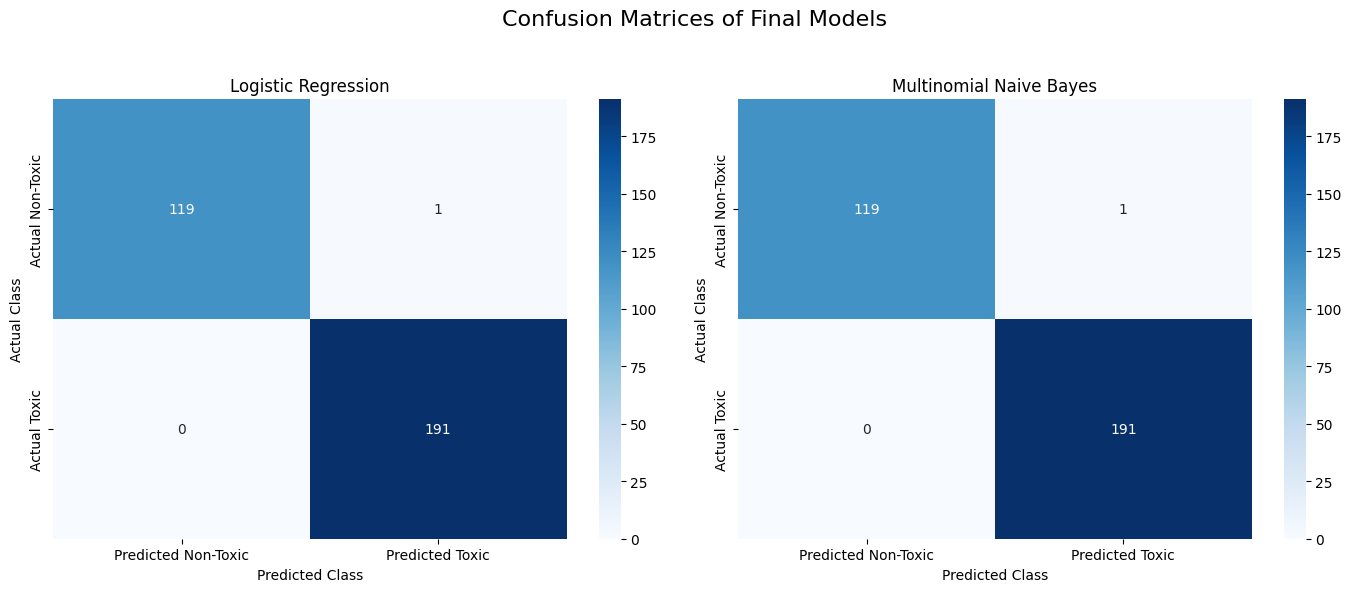

In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# --- 1. Loading and Preparing Data ---

dataset_path = "Datasets/dataset_merged_preprocessed.csv"

if not os.path.exists(dataset_path):
    print(f"[ERROR] File not found: '{dataset_path}'")
else:
    print(f"[INFO] Loading dataset from: '{dataset_path}'")
    df = pd.read_csv(dataset_path)
    df.dropna(subset=['conversation', 'toxic'], inplace=True)
    df['toxic'] = df['toxic'].astype(int)
    print(f"[INFO] Dataset loaded successfully with {df.shape[0]} samples.")

    X = df['conversation']
    y = df['toxic']

    # Split into train and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.20,
        random_state=42,
        stratify=y
    )
    print(f"[INFO] Training set size: {len(X_train)} samples")
    print(f"[INFO] Test set size: {len(X_test)} samples")

    # --- 2. Defining Pipelines and Hyperparameter Grids ---

    pipeline_lr = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
        ('clf', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'))
    ])

    pipeline_nb = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
        ('clf', MultinomialNB())
    ])

    param_grid_lr = {
        'tfidf__max_features': [3000, 5000, 7000],
        'clf__C': [0.1, 1, 10]
    }

    param_grid_nb = {
        'tfidf__max_features': [3000, 5000, 7000],
        'clf__alpha': [0.1, 0.5, 1.0]
    }

    models_to_run = {
        "Logistic Regression": (pipeline_lr, param_grid_lr),
        "Multinomial Naive Bayes": (pipeline_nb, param_grid_nb)
    }

    final_results = {}

    # --- 3. Hyperparameter Optimization and Model Training ---

    for model_name, (pipeline, param_grid) in models_to_run.items():
        print(f"\n[INFO] Starting hyperparameter optimization for: {model_name}")

        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=cv_strategy,
            scoring='f1_weighted',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        print(f"[INFO] Best hyperparameters for {model_name}: {best_params}")

        # Final model trained on full training set with best parameters
        final_model = grid_search.best_estimator_
        print(f"[INFO] Training final model for {model_name} with best parameters.")

        # --- 4. Evaluation on Test Set ---

        y_pred = final_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        report = classification_report(y_test, y_pred, target_names=['Non-Toxic (0)', 'Toxic (1)'])
        conf_matrix = confusion_matrix(y_test, y_pred)

        final_results[model_name] = {
            'best_params': best_params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'report': report,
            'matrix': conf_matrix
        }

    # --- 5. Reporting Results ---

    print("\n" + "=" * 60)
    print("FINAL PERFORMANCE REPORT ON TEST SET")
    print("=" * 60)

    for model_name, results in final_results.items():
        print(f"\n--- Model: {model_name} ---")
        print(f"Best Hyperparameters: {results['best_params']}")
        print("\nPerformance Metrics:")
        print(f"  Accuracy: {results['accuracy']:.4f}")
        print(f"  Precision (weighted): {results['precision']:.4f}")
        print(f"  Recall (weighted): {results['recall']:.4f}")
        print(f"  F1-Score (weighted): {results['f1_score']:.4f}")
        print("\nDetailed Classification Report:")
        print(results['report'])

    # --- 6. Visualizing Confusion Matrices ---

    fig, axes = plt.subplots(1, len(models_to_run), figsize=(14, 6))
    if len(models_to_run) == 1:
        axes = [axes]

    fig.suptitle('Confusion Matrices of Final Models', fontsize=16)

    for i, (model_name, res) in enumerate(final_results.items()):
        sns.heatmap(
            res['matrix'],
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=axes[i],
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic']
        )
        axes[i].set_title(model_name)
        axes[i].set_ylabel('Actual Class')
        axes[i].set_xlabel('Predicted Class')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Logistic Regression vs Naive Bayes, with preprocessing

[INFO] Loading the Italian spaCy model: 'it_core_news_sm'
[INFO] spaCy model loaded successfully.
[INFO] Loading dataset from: 'Datasets/dataset_merged_preprocessed.csv'
[INFO] Dataset loaded with 1555 valid samples.
[INFO] Applying spaCy preprocessing to conversations...


spaCy Preprocessing: 100%|██████████| 1555/1555 [00:29<00:00, 53.61it/s] 


[INFO] Preprocessing completed.
[INFO] Training samples: 1244
[INFO] Test samples: 311

[INFO] Starting grid search for: Logistic Regression (spaCy)
[INFO] Best hyperparameters for Logistic Regression (spaCy): {'clf__C': 10, 'tfidf__max_features': 2000}

[INFO] Starting grid search for: Multinomial Naive Bayes (spaCy)
[INFO] Best hyperparameters for Multinomial Naive Bayes (spaCy): {'clf__alpha': 0.1, 'tfidf__max_features': 6000}

 FINAL PERFORMANCE REPORT (spaCy Preprocessing)

--- Model: Logistic Regression (spaCy) ---
Best Hyperparameters: {'clf__C': 10, 'tfidf__max_features': 2000}

Performance Metrics:
  Accuracy: 0.9936
  Precision (weighted): 0.9936
  Recall (weighted): 0.9936
  F1-Score (weighted): 0.9936

Detailed Classification Report:
               precision    recall  f1-score   support

Non-Toxic (0)       0.99      0.99      0.99       120
    Toxic (1)       0.99      0.99      0.99       191

     accuracy                           0.99       311
    macro avg       0.

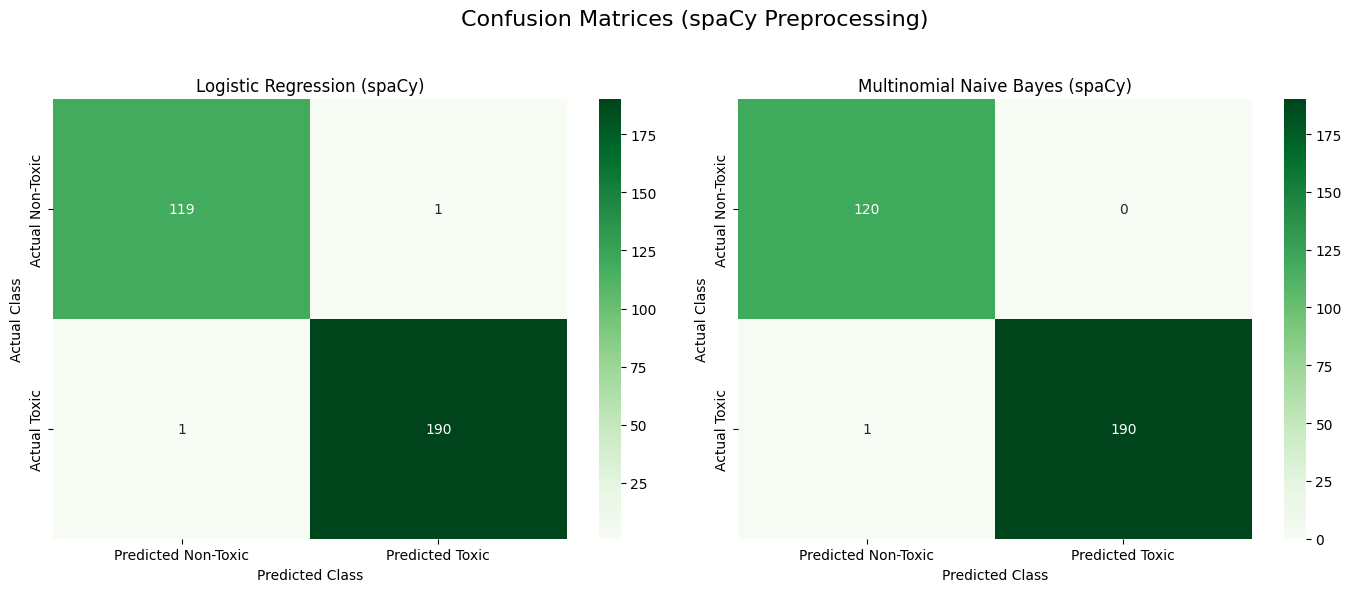

In [8]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from tqdm import tqdm

# --- 1. Load spaCy Model ---

print("[INFO] Loading the Italian spaCy model: 'it_core_news_sm'")
try:
    nlp = spacy.load("it_core_news_sm")
    print("[INFO] spaCy model loaded successfully.")
except IOError:
    print("[ERROR] spaCy model 'it_core_news_sm' not found.")
    print("Please run: python -m spacy download it_core_news_sm")
    exit()

# --- 2. Load and Preprocess Dataset ---

dataset_path = "Datasets/dataset_merged_preprocessed.csv"

if not os.path.exists(dataset_path):
    print(f"[ERROR] Dataset file not found at: '{dataset_path}'")
else:
    print(f"[INFO] Loading dataset from: '{dataset_path}'")
    df = pd.read_csv(dataset_path)
    df.dropna(subset=['conversation', 'toxic'], inplace=True)
    df['toxic'] = df['toxic'].astype(int)
    print(f"[INFO] Dataset loaded with {df.shape[0]} valid samples.")

    # Define preprocessing function using spaCy
    def preprocess_with_spacy(text):
        doc = nlp(str(text).lower())
        lemmas = [
            token.lemma_
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_space
        ]
        return " ".join(lemmas)

    print("[INFO] Applying spaCy preprocessing to conversations...")
    tqdm.pandas(desc="spaCy Preprocessing")
    df['conversation_processed'] = df['conversation'].progress_apply(preprocess_with_spacy)
    print("[INFO] Preprocessing completed.")

    # --- 3. Split Data into Train/Test Sets ---

    X = df['conversation_processed']
    y = df['toxic']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.20,
        random_state=42,
        stratify=y
    )

    print(f"[INFO] Training samples: {len(X_train)}")
    print(f"[INFO] Test samples: {len(X_test)}")

    # --- 4. Define Pipelines and Grids ---

    pipeline_lr = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
        ('clf', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'))
    ])

    pipeline_nb = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
        ('clf', MultinomialNB())
    ])

    param_grid_lr = {
        'tfidf__max_features': [2000, 4000, 6000],
        'clf__C': [0.1, 1, 10]
    }

    param_grid_nb = {
        'tfidf__max_features': [2000, 4000, 6000],
        'clf__alpha': [0.1, 0.5, 1.0]
    }

    models_to_run = {
        "Logistic Regression (spaCy)": (pipeline_lr, param_grid_lr),
        "Multinomial Naive Bayes (spaCy)": (pipeline_nb, param_grid_nb)
    }

    final_results = {}

    # --- 5. Grid Search + Evaluation ---

    for model_name, (pipeline, param_grid) in models_to_run.items():
        print(f"\n[INFO] Starting grid search for: {model_name}")

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='f1_weighted',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        print(f"[INFO] Best hyperparameters for {model_name}: {best_params}")

        final_model = grid_search.best_estimator_
        y_pred = final_model.predict(X_test)

        final_results[model_name] = {
            'best_params': best_params,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1_score': f1_score(y_test, y_pred, average='weighted'),
            'report': classification_report(y_test, y_pred, target_names=['Non-Toxic (0)', 'Toxic (1)']),
            'matrix': confusion_matrix(y_test, y_pred)
        }

    # --- 6. Reporting Results ---

    print("\n" + "=" * 60)
    print(" FINAL PERFORMANCE REPORT (spaCy Preprocessing)")
    print("=" * 60)

    for model_name, res in final_results.items():
        print(f"\n--- Model: {model_name} ---")
        print(f"Best Hyperparameters: {res['best_params']}")
        print("\nPerformance Metrics:")
        print(f"  Accuracy: {res['accuracy']:.4f}")
        print(f"  Precision (weighted): {res['precision']:.4f}")
        print(f"  Recall (weighted): {res['recall']:.4f}")
        print(f"  F1-Score (weighted): {res['f1_score']:.4f}")
        print("\nDetailed Classification Report:")
        print(res['report'])

    # --- 7. Plot Confusion Matrices ---

    fig, axes = plt.subplots(1, len(models_to_run), figsize=(14, 6))
    if len(models_to_run) == 1:
        axes = [axes]

    fig.suptitle("Confusion Matrices (spaCy Preprocessing)", fontsize=16)

    for i, (model_name, res) in enumerate(final_results.items()):
        sns.heatmap(
            res['matrix'],
            annot=True,
            fmt='d',
            cmap='Greens',
            ax=axes[i],
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic']
        )
        axes[i].set_title(model_name)
        axes[i].set_ylabel("Actual Class")
        axes[i].set_xlabel("Predicted Class")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Couple dynamics prediction

### Logistic Regression, with LSA

[INFO] Loading Italian spaCy model: 'it_core_news_sm'
[INFO] spaCy model loaded successfully.

[INFO] Checking dataset file: 'Datasets/dataset_merged_preprocessed.csv'
[INFO] Loading dataset from: 'Datasets/dataset_merged_preprocessed.csv'
[INFO] Dataset contains 1555 valid samples
[INFO] Applying spaCy preprocessing to text


spaCy Preprocessing: 100%|██████████| 1555/1555 [00:27<00:00, 55.72it/s] 


[INFO] Preprocessing completed
[INFO] Detected 15 unique classes
[INFO] Split: 1244 training samples, 311 test samples

[INFO] Starting GridSearchCV (5-fold CV) for hyperparameter tuning
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[INFO] Best hyperparameters found: {'clf__C': 10, 'svd__n_components': 200}

[INFO] Evaluating final model on test set
[RESULT] Test set accuracy: 0.7395

[INFO] Detailed classification report:
                                          precision    recall  f1-score   support

                   Controllore E Isolata       0.46      0.63      0.53        19
             Dominante E Schiavo Emotivo       0.78      0.74      0.76        19
           Geloso-Ossessivo E Sottomessa       0.60      0.32      0.41        19
                     Grato e Apprezzante       1.00      1.00      1.00        26
                   Insicuro e Supportivo       0.76      0.81      0.79        16
       Manipolatore E Dipendente Emotiva       0.42      0.58     

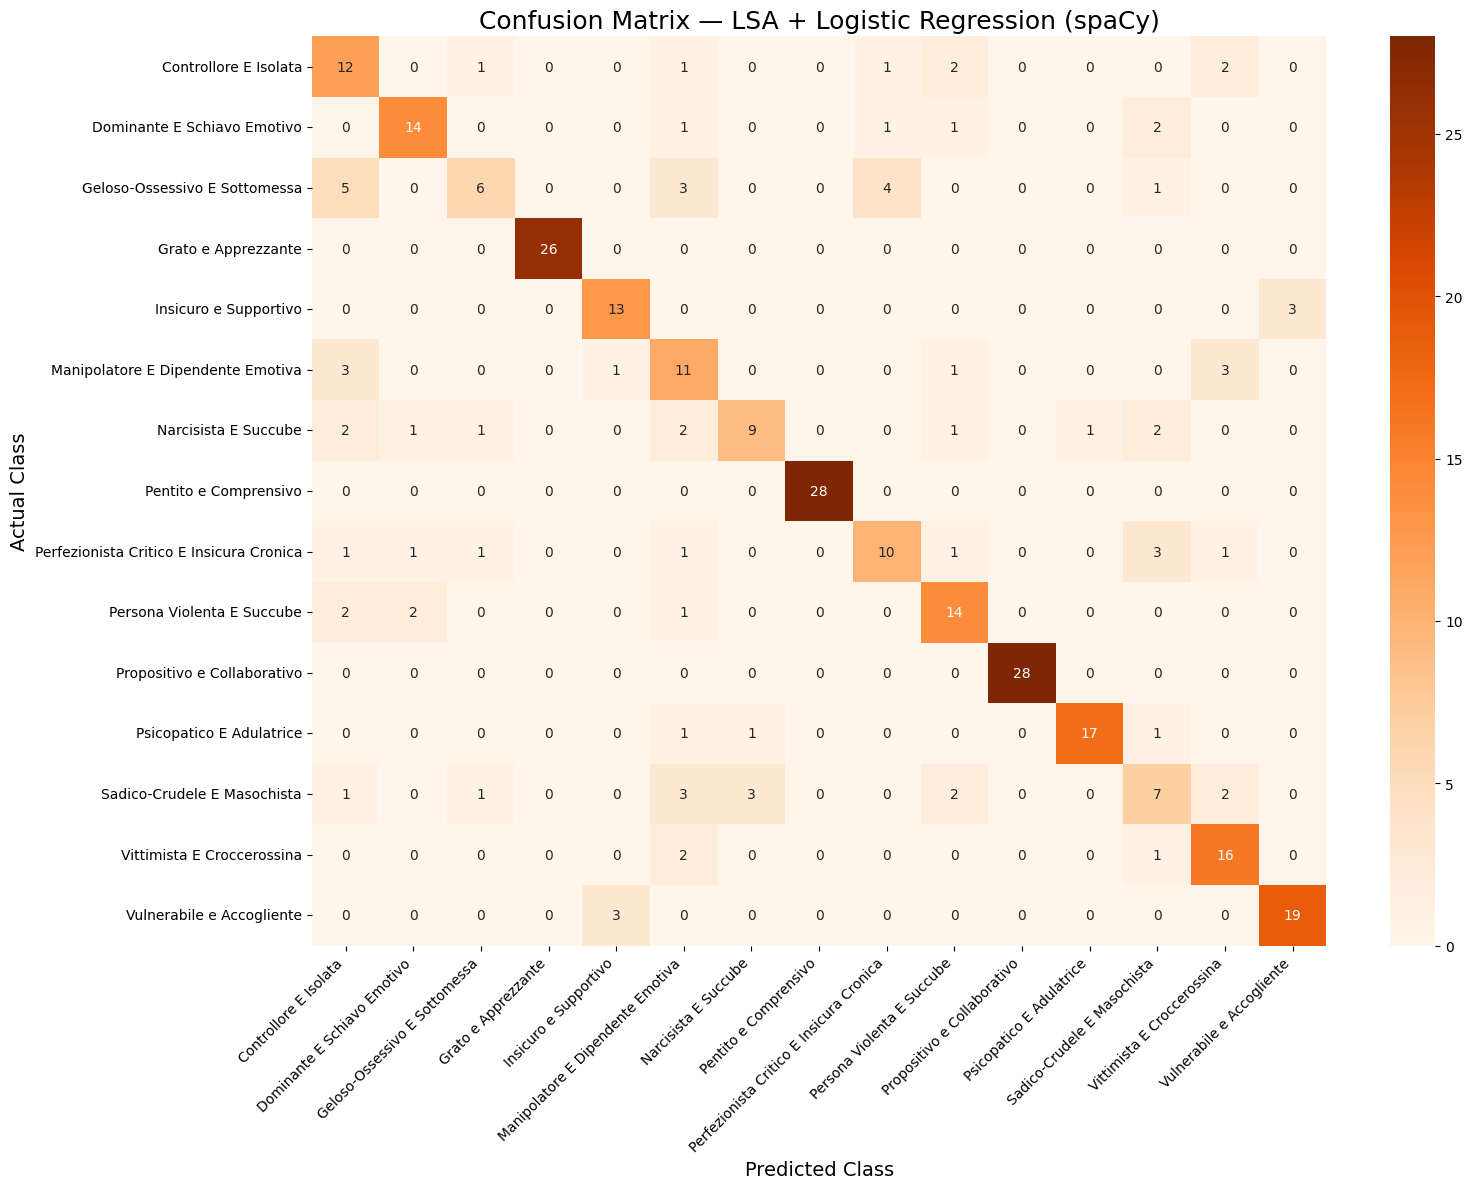

In [12]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# --- 1. Load spaCy Model ---

print("[INFO] Loading Italian spaCy model: 'it_core_news_sm'")
try:
    nlp = spacy.load("it_core_news_sm")
    print("[INFO] spaCy model loaded successfully.")
except IOError:
    print("[ERROR] spaCy model 'it_core_news_sm' not found.")
    print("[ACTION] Run: python -m spacy download it_core_news_sm")
    exit()

# --- 2. Load & Preprocess Dataset ---

dataset_path = "Datasets/dataset_merged_preprocessed.csv"
print(f"\n[INFO] Checking dataset file: '{dataset_path}'")
if not os.path.exists(dataset_path):
    print(f"[ERROR] File not found: '{dataset_path}'")
    exit()
print(f"[INFO] Loading dataset from: '{dataset_path}'")
df = pd.read_csv(dataset_path)
df.dropna(subset=['conversation', 'person_couple'], inplace=True)
print(f"[INFO] Dataset contains {df.shape[0]} valid samples")

print("[INFO] Applying spaCy preprocessing to text")
def preprocess_with_spacy(text):
    doc = nlp(str(text).lower())
    return " ".join(
        token.lemma_ for token in doc 
        if not token.is_stop and not token.is_punct and not token.is_space
    )

tqdm.pandas(desc="spaCy Preprocessing")
df['conversation_processed'] = df['conversation'].progress_apply(preprocess_with_spacy)
print("[INFO] Preprocessing completed")

# Encode labels
X = df['conversation_processed']
y_labels = df['person_couple']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)
class_names = list(label_encoder.classes_)
print(f"[INFO] Detected {len(class_names)} unique classes")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"[INFO] Split: {len(X_train)} training samples, {len(X_test)} test samples")

# --- 3. Build LSA + Logistic Regression Pipeline ---

lsa_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(random_state=42)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'))
])

param_grid = {
    'svd__n_components': [100, 200, 300],
    'clf__C': [0.1, 1, 10]
}

print("\n[INFO] Starting GridSearchCV (5-fold CV) for hyperparameter tuning")
grid_search = GridSearchCV(
    estimator=lsa_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"[INFO] Best hyperparameters found: {best_params}")

final_model = grid_search.best_estimator_

# --- 4. Evaluate on Test Set ---

print("\n[INFO] Evaluating final model on test set")
y_pred = final_model.predict(X_test)
y_true_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"[RESULT] Test set accuracy: {accuracy:.4f}")

print("\n[INFO] Detailed classification report:")
print(classification_report(
    y_true_labels, y_pred_labels, zero_division=0, target_names=class_names
))

# --- 5. Plot Confusion Matrix ---

print("[INFO] Plotting confusion matrix")
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=class_names)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix — LSA + Logistic Regression (spaCy)', fontsize=18)
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### BERT, no fine-tuning

[INFO] Checking dataset file: 'Datasets/dataset_merged_preprocessed.csv'
[INFO] Loading dataset from: 'Datasets/dataset_merged_preprocessed.csv'
[INFO] Dataset loaded with 1555 valid samples

[INFO] Loading BERT model and tokenizer: 'dbmdz/bert-base-italian-uncased'
[INFO] BERT model running on: cuda

[INFO] Generating BERT embeddings for conversations


BERT Embedding: 100%|██████████| 1555/1555 [00:31<00:00, 49.20it/s]


[INFO] BERT embeddings generation completed
[INFO] Detected 15 unique classes
[INFO] Split: 1244 training samples, 311 test samples

[INFO] Training Logistic Regression classifier on BERT embeddings

[RESULT] Test set accuracy: 0.7010

[INFO] Detailed classification report:
                                          precision    recall  f1-score   support

                   Controllore E Isolata       0.48      0.53      0.50        19
             Dominante E Schiavo Emotivo       0.72      0.68      0.70        19
           Geloso-Ossessivo E Sottomessa       0.36      0.21      0.27        19
                     Grato e Apprezzante       0.89      0.92      0.91        26
                   Insicuro e Supportivo       0.80      0.75      0.77        16
       Manipolatore E Dipendente Emotiva       0.44      0.58      0.50        19
                    Narcisista E Succube       0.62      0.42      0.50        19
                   Pentito e Comprensivo       1.00      1.00      1

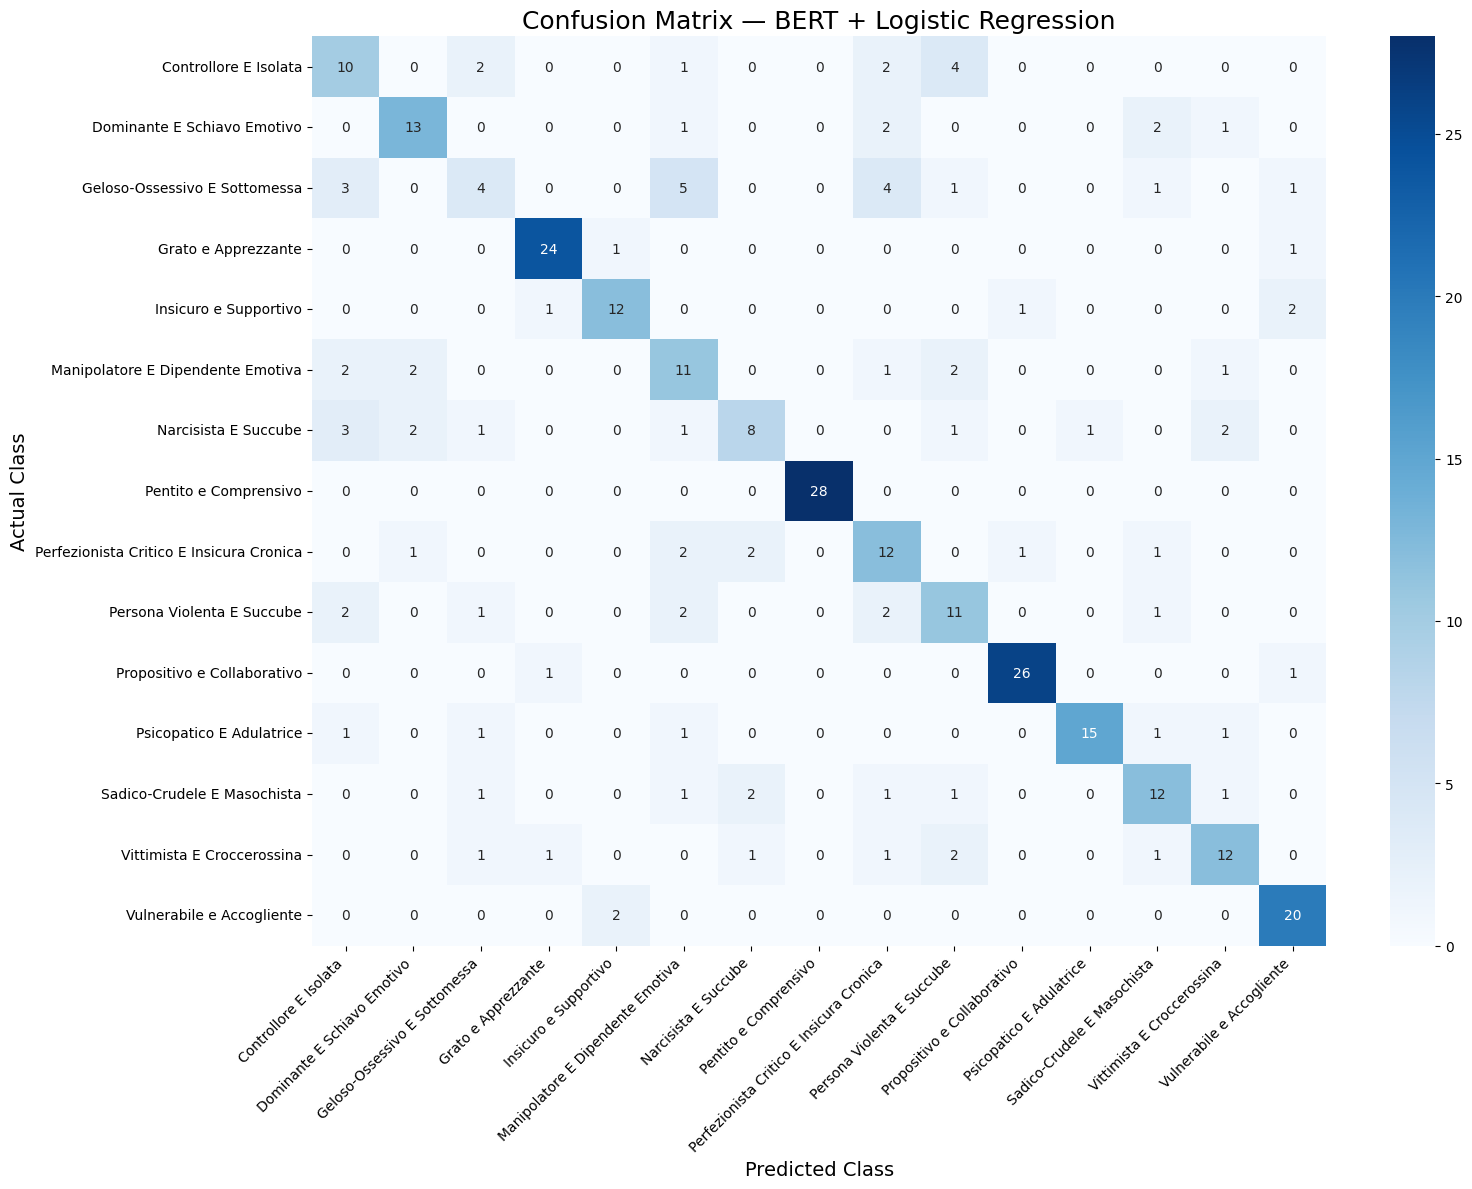

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# --- 1. Load Dataset ---

dataset_path = "Datasets/dataset_merged_preprocessed.csv"
print(f"[INFO] Checking dataset file: '{dataset_path}'")

if not os.path.exists(dataset_path):
    print(f"[ERROR] File not found: '{dataset_path}'")
    exit()

print(f"[INFO] Loading dataset from: '{dataset_path}'")
df = pd.read_csv(dataset_path)
df.dropna(subset=['conversation', 'person_couple'], inplace=True)
print(f"[INFO] Dataset loaded with {df.shape[0]} valid samples")

# --- 2. Load BERT Model ---

MODEL_NAME = 'dbmdz/bert-base-italian-uncased'
print(f"\n[INFO] Loading BERT model and tokenizer: '{MODEL_NAME}'")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"[INFO] BERT model running on: {device}")

# --- 3. BERT Embedding Extraction ---

def get_bert_embedding(text, tokenizer, model):
    encoded_input = tokenizer(
        text, padding=True, truncation=True, max_length=512, return_tensors='pt'
    )
    encoded_input = {key: val.to(device) for key, val in encoded_input.items()}
    with torch.no_grad():
        outputs = model(**encoded_input)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()

print("\n[INFO] Generating BERT embeddings for conversations")
tqdm.pandas(desc="BERT Embedding")
df['bert_embedding'] = df['conversation'].progress_apply(
    lambda x: get_bert_embedding(x, tokenizer, model)
)
print("[INFO] BERT embeddings generation completed")

# --- 4. Train Classifier ---

X = np.array(df['bert_embedding'].tolist())
y_labels = df['person_couple']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)
class_names = label_encoder.classes_

print(f"[INFO] Detected {len(class_names)} unique classes")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"[INFO] Split: {len(X_train)} training samples, {len(X_test)} test samples")

classifier = LogisticRegression(random_state=42, max_iter=2000, C=0.1)
print("\n[INFO] Training Logistic Regression classifier on BERT embeddings")
classifier.fit(X_train, y_train)

# --- 5. Evaluation ---

y_pred = classifier.predict(X_test)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"\n[RESULT] Test set accuracy: {accuracy:.4f}")

print("\n[INFO] Detailed classification report:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0, target_names=class_names))

# --- 6. Confusion Matrix ---

print("[INFO] Plotting confusion matrix")
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — BERT + Logistic Regression', fontsize=18)
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### BERT, with fine-tuning

[INFO] Checking dataset file: 'Datasets/dataset_merged_preprocessed.csv'
[INFO] Loading dataset from: 'Datasets/dataset_merged_preprocessed.csv'
[INFO] Dataset loaded with 1555 valid samples
[INFO] Detected 15 unique classes
[INFO] Split: 1244 training, 155 validation, 156 test samples
[INFO] Loading BERT model & tokenizer: 'dbmdz/bert-base-italian-uncased'


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[INFO] Starting BERT fine-tuning with regularization and early stopping


Epoch,Training Loss,Validation Loss,Accuracy
1,2.572100,2.060783,0.329032
2,1.558000,1.087405,0.690323
3,0.900200,0.835453,0.741935
4,0.549500,0.768743,0.741935
5,0.304700,0.746255,0.774194
6,0.121700,0.786308,0.806452
7,0.051300,0.831436,0.806452


[INFO] Fine-tuning completed


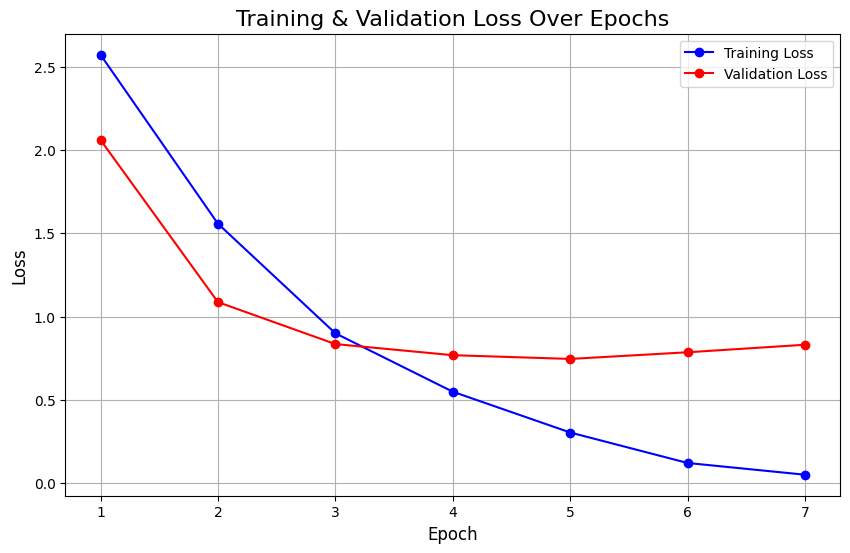

[INFO] Evaluating on test set



[RESULT] Test set accuracy: 0.8013

[INFO] Detailed classification report:
                                          precision    recall  f1-score   support

                   Controllore E Isolata       0.75      0.33      0.46         9
             Dominante E Schiavo Emotivo       0.60      0.67      0.63         9
           Geloso-Ossessivo E Sottomessa       1.00      0.50      0.67        10
                     Grato e Apprezzante       1.00      0.92      0.96        13
                   Insicuro e Supportivo       0.73      1.00      0.84         8
       Manipolatore E Dipendente Emotiva       0.59      1.00      0.74        10
                    Narcisista E Succube       0.62      0.50      0.56        10
                   Pentito e Comprensivo       1.00      1.00      1.00        14
Perfezionista Critico E Insicura Cronica       0.64      0.78      0.70         9
              Persona Violenta E Succube       0.62      0.80      0.70        10
             Proposit

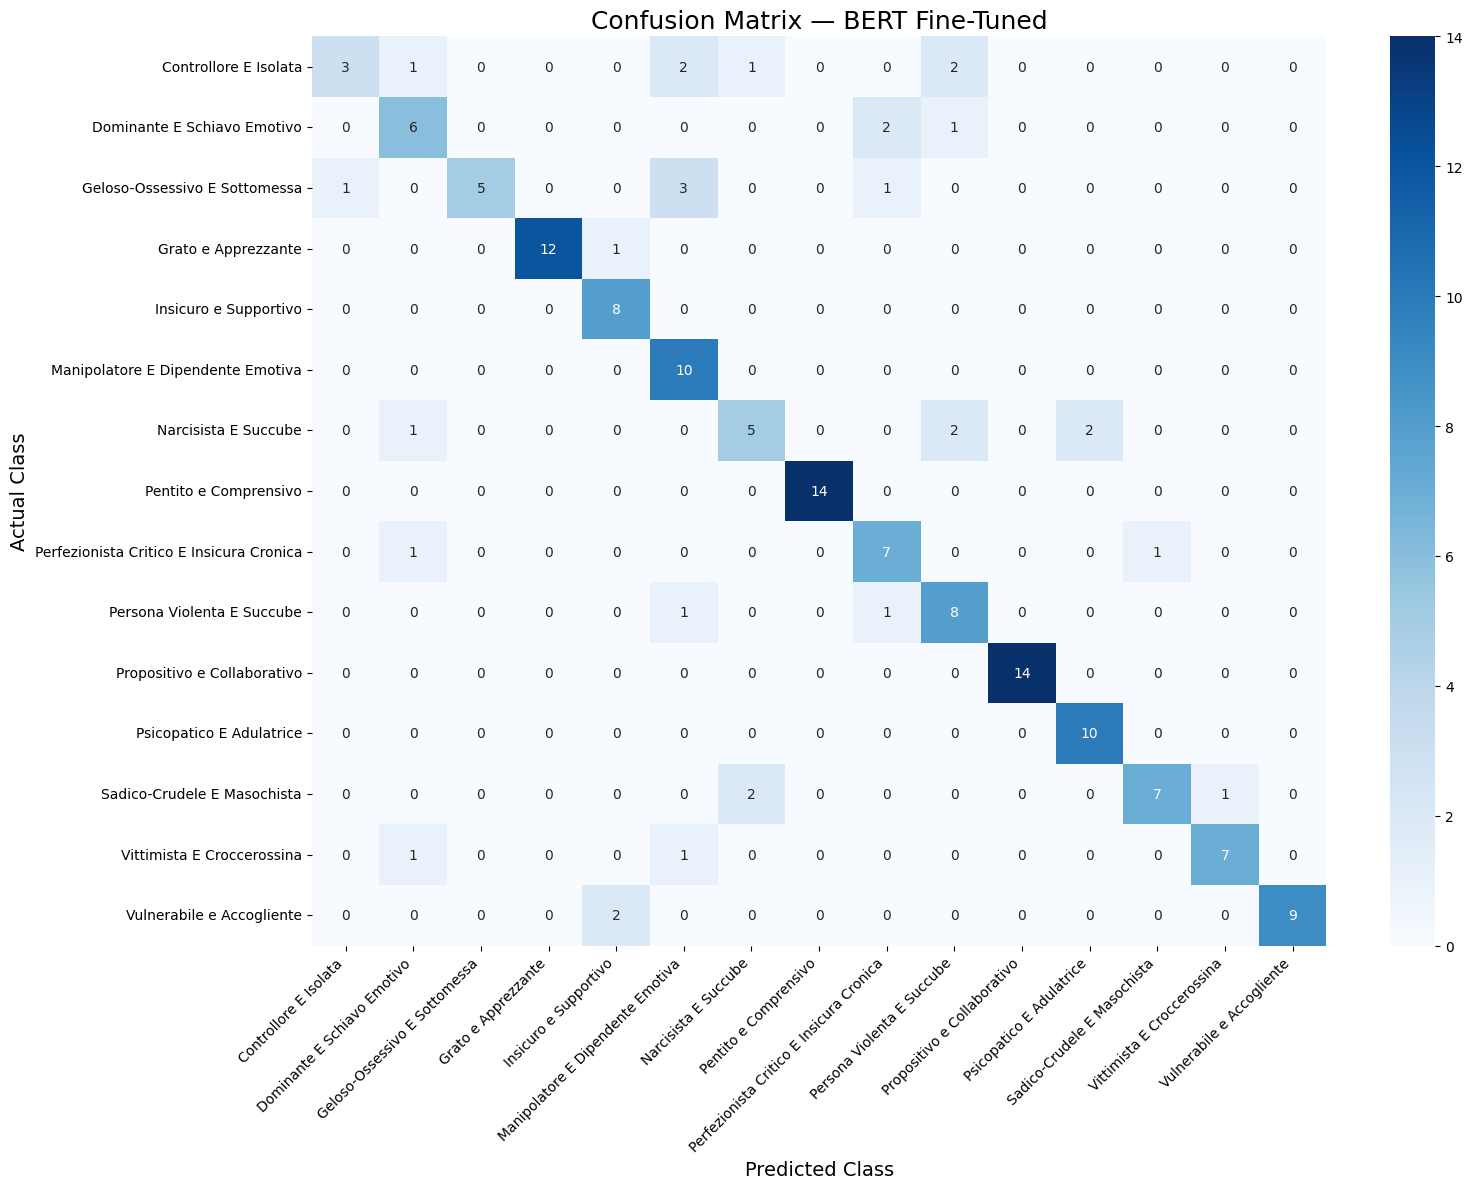

In [10]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# --- 1. Load Dataset ---

dataset_path = "Datasets/dataset_merged_preprocessed.csv"
print(f"[INFO] Checking dataset file: '{dataset_path}'")

if not os.path.exists(dataset_path):
    print(f"[ERROR] File not found: '{dataset_path}'")
    exit()

print(f"[INFO] Loading dataset from: '{dataset_path}'")
df = pd.read_csv(dataset_path)
df.dropna(subset=['conversation', 'person_couple'], inplace=True)
df.rename(columns={'conversation': 'text', 'person_couple': 'label'}, inplace=True)
print(f"[INFO] Dataset loaded with {df.shape[0]} valid samples")

# --- 2. Encode Labels ---

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
class_names = list(label_encoder.classes_)
num_labels = len(class_names)
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}
print(f"[INFO] Detected {num_labels} unique classes")

# --- 3. Split Data ---

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['label_encoded'].tolist(),
    test_size=0.2, random_state=42, stratify=df['label_encoded'].tolist()
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, random_state=42, stratify=temp_labels
)
print(f"[INFO] Split: {len(train_texts)} training, {len(val_texts)} validation, {len(test_texts)} test samples")

# --- 4. Tokenizer and Dataset ---

MODEL_NAME = 'dbmdz/bert-base-italian-uncased'
print(f"[INFO] Loading BERT model & tokenizer: '{MODEL_NAME}'")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class CoupleConversationDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = CoupleConversationDataset(train_texts, train_labels)
val_dataset = CoupleConversationDataset(val_texts, val_labels)
test_dataset = CoupleConversationDataset(test_texts, test_labels)

# --- 5. Load BERT Model ---

model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id
)

# --- 6. Training Setup ---

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

training_args = TrainingArguments(
    output_dir='./results_bert_finetuned',
    save_total_limit=1,
    num_train_epochs=7,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_bert',
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# --- 7. Fine-Tune BERT ---

print("\n[INFO] Starting BERT fine-tuning with regularization and early stopping")
trainer.train()
print("[INFO] Fine-tuning completed")

# --- 8. Plot Learning Curves ---

log_history = trainer.state.log_history
train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
epochs = [log['epoch'] for log in log_history if 'eval_loss' in log]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, eval_loss, 'r-o', label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 9. Evaluation on Test Set ---

print("[INFO] Evaluating on test set")
test_results = trainer.predict(test_dataset)
y_pred_encoded = np.argmax(test_results.predictions, axis=-1)
y_test_encoded = test_results.label_ids

y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"\n[RESULT] Test set accuracy: {accuracy:.4f}")

print("\n[INFO] Detailed classification report:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0, target_names=class_names))

# --- 10. Confusion Matrix ---

print("[INFO] Plotting confusion matrix")
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — BERT Fine-Tuned', fontsize=18)
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Most toxic phrase recognition

### BERT, with 0/1 classification

[INFO] Using device: cuda
[INFO] Loading dataset from: Datasets/dataset_merged_preprocessed.csv
[INFO] Found 957 toxic conversations
[INFO] Extracted 7613 individual messages
[INFO] Loading model and tokenizer: dbmdz/bert-base-italian-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Split: 6090 train, 761 val, 762 test samples
[INFO] Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.315400,0.266048,0.894875
2,0.242600,0.253540,0.889619
3,0.339900,0.246713,0.888305
4,0.179200,0.304183,0.896189
5,0.127200,0.322335,0.879106


[INFO] Training completed.


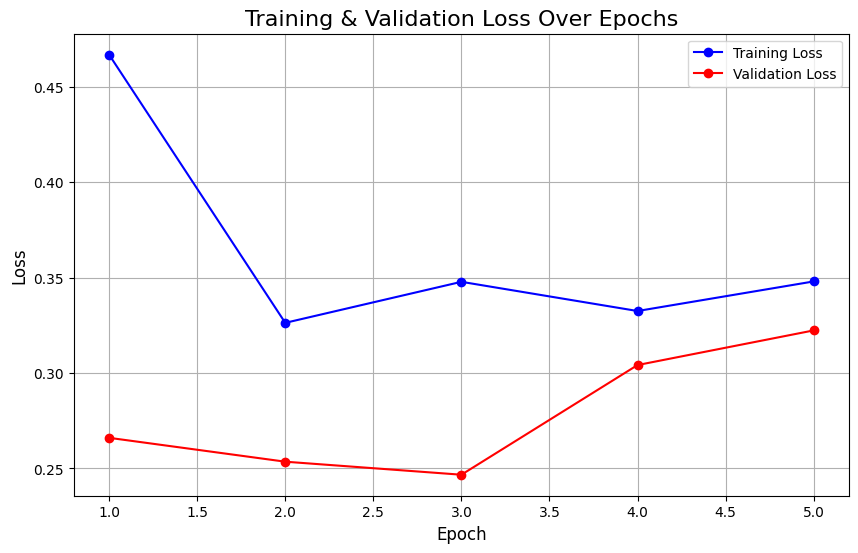

[INFO] Evaluating on test set...



[RESULT] Test set accuracy: 0.8740

[INFO] Detailed classification report:
              precision    recall  f1-score   support

   Non-Toxic       0.91      0.96      0.93       679
       Toxic       0.36      0.20      0.26        83

    accuracy                           0.87       762
   macro avg       0.63      0.58      0.60       762
weighted avg       0.85      0.87      0.86       762



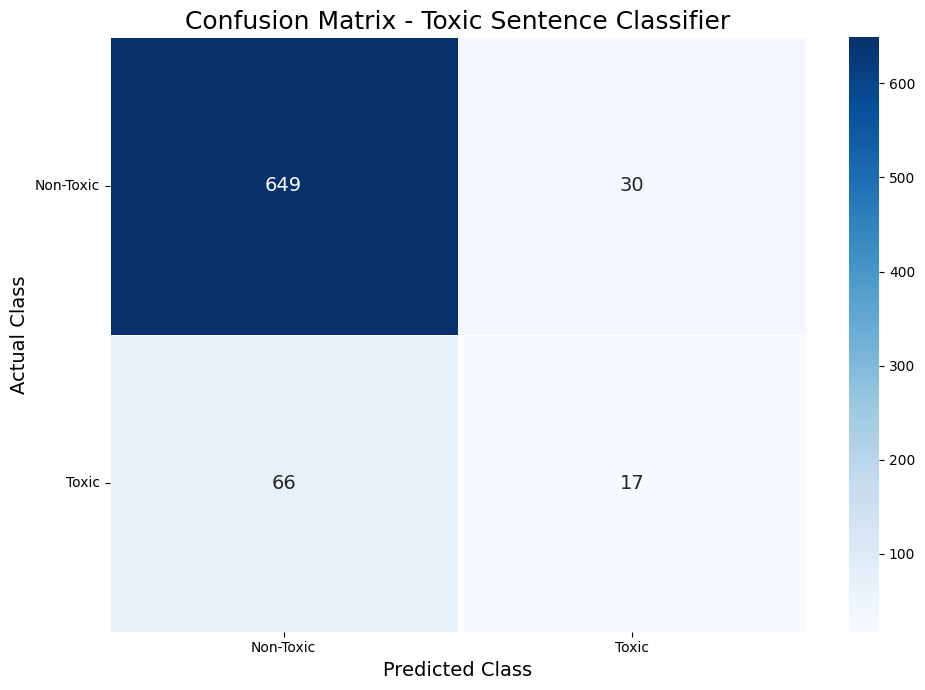


[INFO] Example prediction on new data:
Most toxic sentence: 'Sei inutile' (score: 0.2552)


In [ ]:
import re
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, Subset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Configurazione Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}")

# --- 2. Caricamento e Preparazione Dataset ---
dataset_path = "Datasets/dataset_merged_preprocessed.csv"
print(f"[INFO] Loading dataset from: {dataset_path}")
df = pd.read_csv(dataset_path)
df = df[df["toxic"] == 1].reset_index(drop=True)
print(f"[INFO] Found {df.shape[0]} toxic conversations")

# --- 3. Estrazione dei messaggi e etichettatura ---
def split_conversation(row):
    messages = re.findall(r'"([^\"]+)"', row["conversation"])
    toxic_phrase = row["most_toxic_sentence"].strip()
    result = []
    for msg in messages:
        msg_strip = msg.strip()
        label = 1 if toxic_phrase in msg_strip else 0
        result.append({
            "person_couple": row["person_couple"],
            "sentence": msg_strip,
            "label": label
        })
    return result

rows = []
for _, row in df.iterrows():
    rows.extend(split_conversation(row))
sent_df = pd.DataFrame(rows)
print(f"[INFO] Extracted {len(sent_df)} individual messages")

# --- 4. Dataset Custom ---
class ToxicSentenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        context = r['person_couple']
        encoding = self.tokenizer(
            r['sentence'], context,
            truncation='only_first',
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(r['label'], dtype=torch.long)
        }

# --- 5. Tokenizer e Modello ---
MODEL_NAME = 'dbmdz/bert-base-italian-uncased'
print(f"[INFO] Loading model and tokenizer: {MODEL_NAME}")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

dataset = ToxicSentenceDataset(sent_df, tokenizer)
labels = sent_df['label'].tolist()
indices = list(range(len(dataset)))

# --- 6. Split dati ---
train_idx, temp_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_labels, random_state=42
)
train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)
test_ds = Subset(dataset, test_idx)

print(f"[INFO] Split: {len(train_ds)} train, {len(val_ds)} val, {len(test_ds)} test samples")

# --- 7. Metriche ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# --- 8. Trainer Config ---
training_args = TrainingArguments(
    output_dir='./results_most_toxic_classifier',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_dir='./logs_toxic_classifier',
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# --- 9. Training ---
print("[INFO] Starting training...")
trainer.train()
print("[INFO] Training completed.")

# --- 10. Learning Curves ---
log_history = trainer.state.log_history
train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
epochs = [log['epoch'] for log in log_history if 'eval_loss' in log]

train_epochs = [log['epoch'] for log in log_history if 'loss' in log]
loss_df = pd.DataFrame({'epoch': train_epochs, 'loss': train_loss})
avg_train_loss = loss_df.groupby('epoch').mean()['loss'].tolist()

plt.figure(figsize=(10, 6))
plt.plot(epochs, avg_train_loss[:len(epochs)], 'b-o', label='Training Loss')
plt.plot(epochs, eval_loss, 'r-o', label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 11. Evaluation on Test Set ---
print("[INFO] Evaluating on test set...")
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

accuracy = accuracy_score(y_true, y_pred)
print(f"\n[RESULT] Test set accuracy: {accuracy:.4f}")
print("\n[INFO] Detailed classification report:")
print(classification_report(y_true, y_pred, zero_division=0, target_names=['Non-Toxic', 'Toxic']))

# --- 12. Confusion Matrix ---
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Non-Toxic', 'Toxic'], columns=['Non-Toxic', 'Toxic'])

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, linewidths=.5)
plt.title('Confusion Matrix - Toxic Sentence Classifier', fontsize=18)
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 13. Predict New Conversation ---
def predict_most_toxic(conversation: str, person_couple: str):
    messages = re.findall(r'"([^\"]+)"', conversation)
    if not messages:
        print("[WARN] No messages found in the conversation.")
        return None, 0.0
    contexts = [person_couple] * len(messages)
    enc = tokenizer(
        messages, contexts,
        truncation='only_first', padding='max_length', max_length=128,
        return_tensors='pt'
    )
    input_ids = enc['input_ids'].to(device)
    attention_mask = enc['attention_mask'].to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        probs = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
    idx = torch.argmax(probs).item()
    return messages[idx], probs[idx].item()

print("\n[INFO] Example prediction on new data:")
example_convo = '["Sei inutile", "Non capisci mai niente", "Forse dovremmo parlarne con calma"]'
example_context = "Coppia_A"
most_toxic, score = predict_most_toxic(example_convo, example_context)
print(f"Most toxic sentence: '{most_toxic}' (score: {score:.4f})")

### BART, with most toxic phrase generation

[INFO] Using device: cuda
[INFO] Loading dataset from: Datasets/dataset_merged_preprocessed.csv
[INFO] Found 957 toxic conversations
[INFO] Split: 765 train, 96 val, 96 test samples
[INFO] Loading model and tokenizer: facebook/bart-base
[INFO] Starting training...


C:\Users\Davide\AppData\Roaming\Python\Python312\site-packages\transformers\data\data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Epoch,Training Loss,Validation Loss
1,0.240300,0.204670
2,0.121600,0.177352
3,0.159800,0.159270
4,0.116100,0.174888
5,0.093600,0.150762
6,0.128600,0.156361
7,0.041600,0.159938


C:\Users\Davide\AppData\Roaming\Python\Python312\site-packages\transformers\modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


[INFO] Training completed.
[INFO] Generating learning curves...


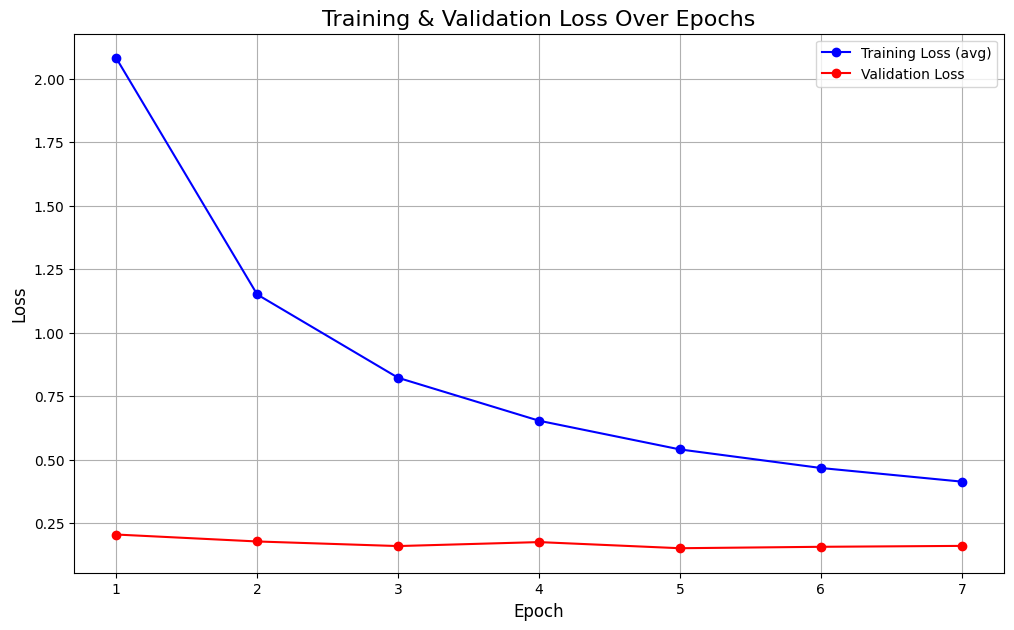

[INFO] Evaluating model on test set...


Evaluating: 100%|██████████| 96/96 [00:58<00:00,  1.63it/s]


[RESULT] Test set performance:


,Metric,Average Score
0,BLEU,0.170634
1,ROUGE-1,0.303083
2,ROUGE-2,0.217040
3,ROUGE-L,0.298656


In [ ]:
import re
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from sklearn.model_selection import GroupShuffleSplit
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. Device Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}")

# --- 2. Load and Filter Dataset ---
dataset_path = "Datasets/dataset_merged_preprocessed.csv"
print(f"[INFO] Loading dataset from: {dataset_path}")
df = pd.read_csv(dataset_path)
df = df[df["toxic"] == 1].reset_index(drop=True)
print(f"[INFO] Found {df.shape[0]} toxic conversations")

# --- 3. Dataset Class ---
class ToxicGenDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        self.encodings = tokenizer(
            [f"Conversazione: {row['conversation']}" for _, row in df.iterrows()],
            truncation=True, padding='max_length', max_length=max_len
        )
        self.targets = tokenizer(
            [row['most_toxic_sentence'] for _, row in df.iterrows()],
            truncation=True, padding='max_length', max_length=64
        )

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.targets['input_ids'][idx])
        }

# --- 4. Split Dataset ---
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, temp_idx = next(gss.split(df, groups=df.index))
temp_df = df.iloc[temp_idx].reset_index(drop=True)
gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(gss2.split(temp_df, groups=temp_df.index))
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

print(f"[INFO] Split: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test samples")

# --- 5. Tokenizer and Model ---
model_name = "facebook/bart-base"
print(f"[INFO] Loading model and tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

train_dataset = ToxicGenDataset(train_df, tokenizer)
val_dataset = ToxicGenDataset(val_df, tokenizer)
test_dataset = ToxicGenDataset(test_df, tokenizer)
collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# --- 6. Trainer Configuration ---
training_args = TrainingArguments(
    output_dir="./results_bart_toxic_gen",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=7,
    learning_rate=3e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# --- 7. Train ---
print("[INFO] Starting training...")
trainer.train()
print("[INFO] Training completed.")

# --- 8. Learning Curves ---
print("[INFO] Generating learning curves...")
log_history = trainer.state.log_history
train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

eval_loss = [log['eval_loss'] for log in eval_logs]
epochs = [log['epoch'] for log in eval_logs]

train_loss_df = pd.DataFrame(train_logs)
avg_train_loss = []
for epoch in epochs:
    avg_loss = train_loss_df[train_loss_df['epoch'] <= epoch]['loss'].mean()
    avg_train_loss.append(avg_loss)

plt.figure(figsize=(12, 7))
plt.plot(epochs, avg_train_loss, 'b-o', label='Training Loss (avg)')
plt.plot(epochs, eval_loss, 'r-o', label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

# --- 9. Prediction Function ---
def generate_toxic(conversation: str):
    enc = tokenizer(f"Conversazione: {conversation}", return_tensors='pt').to(device)
    model.eval()
    with torch.no_grad():
        output = model.generate(**enc, max_new_tokens=64, num_beams=4, early_stopping=True)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# --- 10. Evaluation on Test Set ---
print("[INFO] Evaluating model on test set...")
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smooth = SmoothingFunction().method1

bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating"):
    conv = row['conversation']
    target = row['most_toxic_sentence'].strip()
    prediction = generate_toxic(conv)
    
    bleu = sentence_bleu([target.split()], prediction.split(), smoothing_function=smooth)
    bleu_scores.append(bleu)
    
    scores = scorer.score(target, prediction)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

results_df = pd.DataFrame({
    'Metric': ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Average Score': [avg_bleu, avg_rouge1, avg_rouge2, avg_rougeL]
})

print("\n[RESULT] Test set performance:")
display(results_df)

# ALL TOGHETHER, web-app

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
import gradio as gr

# --- 1. Load Models and Tokenizers ---

# Multiclass model for couple dynamic classification
pair_tokenizer = AutoTokenizer.from_pretrained('dbmdz/bert-base-italian-uncased')
pair_model = AutoModelForSequenceClassification.from_pretrained('results_bert_finetuned/checkpoint-780')
pair_model.eval()

# Sentence-level toxic phrase classifier
toxic_tokenizer = AutoTokenizer.from_pretrained('dbmdz/bert-base-italian-uncased')
toxic_model = AutoModelForSequenceClassification.from_pretrained('results_most_toxic_classifier/checkpoint-573')
toxic_model.eval()

# Toxic phrase generation model
gen_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')
gen_model = AutoModelForSeq2SeqLM.from_pretrained('results_bart_toxic_gen/checkpoint-960')
gen_model.eval()

# --- 2. Define Couple Dynamic Labels ---

LABELS = [
    "Controllore E Isolata",
    "Dominante E Schiavo Emotivo",
    "Geloso-Ossessivo E Sottomessa",
    "Grato e Apprezzante",
    "Insicuro e Supportivo",
    "Manipolatore E Dipendente Emotiva",
    "Narcisista E Succube",
    "Pentito e Comprensivo",
    "Perfezionista Critico E Insicura Cronica",
    "Persona Violenta E Succube",
    "Propositivo e Collaborativo",
    "Psicopatico E Adulatrice",
    "Sadico-Crudele E Masochista",
    "Vittimista E Croccerossina",
    "Vulnerabile e Accogliente"
]

# Labels considered toxic
TOXIC_LABELS = {
    "Controllore E Isolata",
    "Dominante E Schiavo Emotivo",
    "Geloso-Ossessivo E Sottomessa",
    "Manipolatore E Dipendente Emotiva",
    "Narcisista E Succube",
    "Persona Violenta E Succube",
    "Psicopatico E Adulatrice",
    "Sadico-Crudele E Masochista",
    "Vittimista E Croccerossina",
    "Perfezionista Critico E Insicura Cronica"
}

# --- 3. Inference Functions ---

def classify_person_couple(messages):
    """Classify overall couple dynamic based on conversation messages."""
    text = " ".join(messages)
    inputs = pair_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        logits = pair_model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)[0]
    idx = torch.argmax(probs).item()
    return LABELS[idx], probs[idx].item()

def predict_most_toxic(messages, context_label):
    """Identify the most toxic sentence in messages given the couple dynamic context."""
    contexts = [context_label] * len(messages)
    enc = toxic_tokenizer(messages, contexts, truncation='only_first', padding=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        logits = toxic_model(enc['input_ids'], attention_mask=enc['attention_mask']).logits
        probs = torch.softmax(logits, dim=-1)[:, 1]  # Probability of toxic class
    idx = torch.argmax(probs).item()
    return messages[idx], probs[idx].item()

def generate_toxic_message(messages):
    """Generate a toxic sentence summary from conversation messages."""
    convo = " ".join(messages)
    enc = gen_tokenizer(f"Conversation: {convo}", return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        out = gen_model.generate(**enc, max_new_tokens=64, num_beams=4, early_stopping=True)
    return gen_tokenizer.decode(out[0], skip_special_tokens=True)

# --- 4. Gradio Callbacks ---

def respond(message, history):
    """Handle chat input and update conversation history with classification."""
    if history is None:
        history = []
    history.append(message)
    label, score = classify_person_couple(history)
    is_toxic = label in TOXIC_LABELS
    info = f"Couple dynamic: **{label}** (confidence: {score:.2f})\nToxic couple: **{is_toxic}**"
    history.append(info)
    chat = [(history[i], history[i+1]) for i in range(0, len(history)-1, 2)]
    return chat, history, ""

def extract_toxic(history):
    """Extract and generate toxic sentences based on conversation history."""
    if not history:
        return "", ""
    messages = history[0::2]
    label, _ = classify_person_couple(history)
    classified_sent, classified_prob = predict_most_toxic(messages, label)
    generated_sent = generate_toxic_message(messages)
    return f"Classified toxic sentence: '{classified_sent}' (score {classified_prob:.2f})", f"Generated toxic sentence: '{generated_sent}'"

def reset_all():
    """Reset chat history and output fields."""
    return [], [], "", ""

# --- 5. Gradio Interface ---

with gr.Blocks() as demo:
    gr.Markdown("# Toxic Sentence Analysis and Comparison")
    chatbot = gr.Chatbot()
    state = gr.State([])

    with gr.Row():
        txt = gr.Textbox(placeholder="Type a message...", show_label=False)
        btn_send = gr.Button("Send")
        btn_reset = gr.Button("Reset")

    with gr.Row():
        btn_extract = gr.Button("Extract Toxic Sentences")

    out1 = gr.Textbox(label="Classified Toxic Sentence", interactive=False)
    out2 = gr.Textbox(label="Generated Toxic Sentence", interactive=False)

    txt.submit(respond, inputs=[txt, state], outputs=[chatbot, state, txt])
    btn_send.click(respond, inputs=[txt, state], outputs=[chatbot, state, txt])

    btn_extract.click(extract_toxic, inputs=[state], outputs=[out1, out2])
    btn_reset.click(reset_all, outputs=[chatbot, state, out1, out2])

    demo.launch()

C:\Users\Davide\AppData\Local\Temp\ipykernel_30680\4096120524.py:118: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
